In [1]:
!pip install watermark > /dev/null 2>&1
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy : 1.19.5
pandas: 1.1.5
torch : 1.10.0+cu111



## Preload

Connect gdrive and sync github repo

### Connect Gdrive

In [2]:
# Gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load Repo

In [3]:
%cd "/content/gdrive/My Drive/Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


In [4]:

%%bash
if [ "$PWD" != "/content/gdrive/My Drive/Colab Notebooks" ]; then
    echo "WRONG DIR!"
    exit 1
fi

# Load repo
if [ ! -d "anomaly-detection" ]; then
    git clone https://github.com/karanjitsingh/anomaly-detection 
fi

cd anomaly-detection

# Sync repo
git pull origin master

# Setup plotly 
pip install plotly

Already up to date.


From https://github.com/karanjitsingh/anomaly-detection
 * branch            master     -> FETCH_HEAD


In [5]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/anomaly-detection"
%load_ext autoreload
%autoreload 2

/content/gdrive/MyDrive/Colab Notebooks/anomaly-detection


## Setup

#### Imports

In [6]:
from preprocess_data import *
from utils import *

#### Download and Preprocess Data

In [7]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00245/dataset_fog_release.zip
! mkdir -p data/raw
! mv dataset_fog_release.zip data/raw

--2021-12-03 16:36:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00245/dataset_fog_release.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21443961 (20M) [application/x-httpd-php]
Saving to: ‘dataset_fog_release.zip’

dataset_fog_release 100%[===================>]  20.45M  10.5MB/s    in 2.0s    

2021-12-03 16:36:10 (10.5 MB/s) - ‘dataset_fog_release.zip’ saved [21443961/21443961]



In [8]:
!rm ./data/*
dataset_name, sub, l = ["Daphnet", "3", "gestures"]
dataset = find_data(dataset_name)
generate_data(dataset_name, dataset, sub, l)

rm: cannot remove './data/raw': Is a directory
Checking dataset data/raw/dataset_fog_release.zip
Processing dataset files ...
Generating training files
... file dataset_fog_release/dataset/S02R01.txt -> train_data_0
... file dataset_fog_release/dataset/S02R02.txt -> train_data_1
... file dataset_fog_release/dataset/S04R01.txt -> train_data_2
... file dataset_fog_release/dataset/S05R01.txt -> train_data_3
... file dataset_fog_release/dataset/S05R02.txt -> train_data_4
... file dataset_fog_release/dataset/S06R01.txt -> train_data_5
... file dataset_fog_release/dataset/S06R02.txt -> train_data_6
... file dataset_fog_release/dataset/S07R01.txt -> train_data_7
... file dataset_fog_release/dataset/S07R02.txt -> train_data_8
... file dataset_fog_release/dataset/S08R01.txt -> train_data_9
... file dataset_fog_release/dataset/S09R01.txt -> train_data_10
... file dataset_fog_release/dataset/S10R01.txt -> train_data_11
Generating validation files
... file dataset_fog_release/dataset/S01R01.txt ->

## Code

In [9]:
# Class names for fog dataset
from os import initgroups


class_names = ['No Freeze','Freeze']


class Config():
    n_channels = 9 # number of sensor channels
    len_seq = 24 # Sliding window length
    stride = 1 # Sliding window step
    num_epochs = 20 # Max no. of epochs to train for
    num_batches= 20 # No. of training batches per epoch. -1 means all windows will be presented at least once, up to batchlen times per epoch (unless undersampled)
    batch_size = 1000 # Batch size / width - this many windows of data will be processed at once
    patience= 20 # Patience of early stopping routine. If criteria does not decrease in this many epochs, training is stopped.
    batchlen = 50 # No. of consecutive windows in a batch. If false, the largest number of windows possible is used.
    val_batch_size = 1000 # Batch size for validation/testing. 
    test_batch_size = 10000 # Useful to make this as large as possible given GPU memory, to speed up testing.
    lr = 0.0001 # Initial (max) learning rate
    num_batches_val = 1 # How many batches should we validate on each epoch
    lr_step = 100

    
    def __init__(self, n_channels = 9, len_seq = 24, stride = 1, num_epochs = 20, num_batches= 20, batch_size = 1000, patience= 20, batchlen = 50, val_batch_size = 1000, test_batch_size = 10000, lr = 0.0001, num_batches_val = 1, lr_step = 100):
        self.n_channels = n_channels 
        self.len_seq = len_seq 
        self.stride = stride 
        self.num_epochs = num_epochs 
        self.num_batches= num_batches
        self.batch_size = batch_size 
        self.patience= patience
        self.batchlen = batchlen 
        self.val_batch_size = val_batch_size 
        self.test_batch_size = test_batch_size 
        self.lr = lr 
        self.num_batches_val = num_batches_val 
        self.lr_step = lr_step 
        

def ma(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return np.array(smoothed)


config = Config()
# Load Data
X_test, y_test = load_data('test',config.len_seq,config.stride)
X_train, y_train = load_data('train',config.len_seq,config.stride)
X_val, y_val = load_data('val',config.len_seq,config.stride)


def normalize_signal(data):
    for i in range(len(data)):
        data[i] = data[i]/3000
    return data

normalize_signal(X_test)
normalize_signal(X_train)
normalize_signal(X_val)

# print(X_train)


Got (144190, 9) samples from data/test_data_0
Got (38774, 9) samples from data/test_data_1
Got (70269, 9) samples from data/test_data_2
Got (89645, 9) samples from data/train_data_1
Got (72561, 9) samples from data/train_data_0
Got (109886, 9) samples from data/train_data_3
Got (195737, 9) samples from data/train_data_2
Got (100746, 9) samples from data/train_data_4
Got (175707, 9) samples from data/train_data_5
Got (119525, 9) samples from data/train_data_7
Got (44227, 9) samples from data/train_data_6
Got (50335, 9) samples from data/train_data_8
Got (136589, 9) samples from data/train_data_9
Got (172311, 9) samples from data/train_data_10
Got (193303, 9) samples from data/train_data_11
Got (151987, 9) samples from data/val_data_0
Got (52095, 9) samples from data/val_data_1


[array([[[ 0.02333333,  0.013     , -0.32333332, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02333333,  0.013     , -0.32333332, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02      ,  0.01633333, -0.32      , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.02333333,  0.013     , -0.32      , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02333333,  0.013     , -0.32      , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02333333,  0.013     , -0.32333332, ...,  0.        ,
           0.        ,  0.        ]],
 
        [[ 0.02333333,  0.013     , -0.32333332, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02      ,  0.01633333, -0.32      , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02      ,  0.01633333, -0.32      , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.02333333,  0.013    

## Models

### Sequitur LSTM AE

In [10]:
import copy
from torch.optim.adam import Adam
from preprocess_data import *
from utils import *

import torch
from torch import nn

from datetime import datetime
# Third Party
import torch
import torch.nn as nn

############
# COMPONENTS
############


class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ, use_hidden = True):
        super(Encoder, self).__init__()

        self.use_hidden = use_hidden
        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):
        # x = x.unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                if(self.use_hidden):
                    return self.out_activ(h_n).squeeze()

                return self.out_activ(x).squeeze()

        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, use_hidden = True):
        super(Decoder, self).__init__()

        self.use_hidden = use_hidden
        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        # self.dense_matrix = nn.Parameter(
        #     torch.rand((layer_dims[-1], out_dim), dtype=torch.float),
        #     requires_grad=True
        # )

        # self.output_layer = nn.Linear(layer_dims[-1], out_dim)

    def forward(self, x, seq_len):
        if(self.use_hidden):
            x = x.unsqueeze(1).repeat(1,seq_len,1)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        # x = self.output_layer(x)
        return x
        

######
# MAIN
######


class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Tanh(),
                 out_activ=nn.Tanh(), config=Config(), use_hidden=True):
        super(LSTM_AE, self).__init__()

        self.config: Config = config

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ,
                               out_activ, use_hidden=use_hidden)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1],
                               h_activ, use_hidden=use_hidden)

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x, self.config.len_seq)

        return x


### Training & Testing

In [ ]:
import copy
from torch.optim.adam import Adam
from preprocess_data import *
from utils import *

import torch
from torch import nn

from datetime import datetime

def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        loss += torch.mean(torch.abs(values))
    return loss

class TrainerGeneric():


    def print_stats(self):
        train_stats = np.unique([a for y in self.y_train for a in y],return_counts=True)[1]
        val_stats = np.unique([a for y in self.y_val for a in y],return_counts=True)[1]

        print('Training set statistics:')
        print(len(train_stats),'classes with distribution',train_stats)
        print('Validation set statistics:')
        print(len(val_stats),'classes with distribution',val_stats)

    def print_config(self):
        config = self.config
        print("Configuration:")
        vars = list(filter(lambda x: x[0] != '_', dir(config)) )
        for var in vars:
            print(str(var) + ": ", getattr(config, var))

    def print_model(self):
        # summary(self.net, input_size = (1000,self.config.len_seq * self.config.n_channels))
        pass

    def __init__(self, net, config:Config=Config(), removeAnom = False, shuffle = True, normalize=True, loss = nn.MSELoss(), sparse = False)->None:
        self.config = config
        self.net = net
        self.removeAnom = removeAnom
        self.normalize = normalize
        self.sparse = sparse
        self.shuffle = shuffle

        self.train_on_gpu = config.train_on_gpu = train_on_gpu = torch.cuda.is_available()
        print("Train on GPU? ", train_on_gpu)


        # self.X_train, self.y_train = load_data('train',config.len_seq,config.stride, removeAnom=removeAnom)
        # self.X_val, self.y_val = load_data('val',config.len_seq,config.stride, removeAnom=removeAnom)
        self.X_train, self.y_train = (X_train, y_train)
        self.X_val, self.y_val = (X_val, y_val)


        # normalize
        self.X_train = self.X_train + self.X_val
        self.y_train = self.y_train + self.y_val

        # if removeAnom:
        #     filter = list(map(lambda x: len(x) > config.batchlen*config.len_seq +1 ,self.X_train))
        #     self.X_train = list(np.array(self.X_train)[filter])
        #     self.y_train = list(np.array(self.y_train)[filter])
        # self.y_train = self.y_train + self.y_val
        # len(self.X_train)

        # if normalize:
        #     for i in range(len(self.X_train)):
        #         self.X_train[i] /= 3000
        # for x in self.X_train:
        #     x=x/3000

        net.apply(init_weights)


        self.optimizer = Adam(net.parameters(), lr=config.lr)
        # self.criterion = nn.L1Loss(reduction='sum')
        self.criterion = loss
        
        self.print_model()

    def train(self, denoise=False):
        # criterion = MSELoss(size_average=False)
        optimizer = self.optimizer
        criterion = self.criterion

        config = self.config
        net = self.net

        if(config.train_on_gpu):
            net = net.cuda()

        mean_losses = []
        norms = []
        for epoch in range(1, config.num_epochs + 1):
            net.train()


            # # Reduces learning rate every 50 epochs
            # if not epoch % 50:
            #     for param_group in optimizer.param_groups:
            #         param_group["lr"] = lr * (0.993 ** epoch)

            losses = []

            # for batch in iterate_minibatches_2D(self.X_train, self.y_train, config.batch_size, config.stride, shuffle=True, num_batches=1, batchlen=config.batchlen, drop_last=True):
            for batch in iterate_minibatches_2D(self.X_train, self.y_train, config.batch_size, config.stride, shuffle=self.shuffle, num_batches=config.num_batches, batchlen=config.batchlen, drop_last=True):
                # print("lol")
                x,y ,pos = batch
                # for x in seq:
                x = torch.from_numpy(x)

                if(config.train_on_gpu):
                    x = x.cuda()
                
                optimizer.zero_grad()

                # Forward pass
                x_prime = net(x)

                loss = criterion(x_prime, x)

                # if self.sparse:
                #     l1_loss = sparse_loss(model, img)
                #     # add the sparsity penalty
                #     loss = loss + reg_param * l1_loss
                # running_loss += loss.item()

                # # Backward pass
                loss.backward()
                
                total_norm = 0
                for p in net.parameters():
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
                total_norm = total_norm ** (1. / 2)
                norms.append(total_norm)
                # print(net.parameters()[0].grads)
                
                optimizer.step()
                
                losses.append(loss.item())

            mean_loss = np.mean(losses)
            mean_losses.append(mean_loss)

            print(f"Epoch: {epoch}, Loss: {mean_loss}")

        return mean_losses, norms


    def get_encodings(self, model, train_set):
        self.net.eval()
        encodings = [self.net.encoder(x) for x in train_set]
        return encodings

        
reg_param = 0.01



def train(model, config, loss, shuffle=True):

    trainer = TrainerGeneric(model,config=config, loss = loss,shuffle=shuffle)    
    losses, norms = trainer.train()

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(list(range(len(norms))), norms)
    plt.show()
    plt.plot(list(range(len(losses))), losses)
    plt.show()
    plt.yscale('log')
    plt.plot(list(range(len(losses))), losses)
    plt.show()

    return trainer, losses



In [ ]:
config = Config()
# print(y_test[0][0])
# print(len(X_test[0][0]))

def plot_losses(data, targets, sampling = 1):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    domain = np.arange(len(data))

    # Add traces
    fig.add_trace(
        go.Scatter(x=domain[::sampling], y=data[::sampling], name="Ground Truth", fill = 'tozeroy'),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=domain[::sampling], y=targets[::sampling], name="Auto Encoder Loss"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="Double Y Axis Example"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="xaxis title")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>primary</b> yaxis title", rangemode='nonnegative', secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b> yaxis title", rangemode='nonnegative', secondary_y=True)

    fig.show()

def plot_rep(data, targets, sampling=1):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis

    domain = np.arange(len(data))

    for i in range(targets.shape[1]):
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # Add traces
        fig.add_trace(
            go.Scatter(x=domain, y=data, name="Ground Truth", fill = 'tozeroy'),
            secondary_y=False,
        )

        fig.add_trace(
            go.Scatter(x=domain, y=targets[:,i], name="Auto Encoder Loss"),
            secondary_y=True,
        )

        # Add figure title
        fig.update_layout(
            title_text="Double Y Axis Example"
        )

        # Set x-axis title
        fig.update_xaxes(title_text="xaxis title")

        # Set y-axes titles
        fig.update_yaxes(title_text="<b>primary</b> yaxis title", rangemode='nonnegative', secondary_y=False)
        fig.update_yaxes(title_text="<b>secondary</b> yaxis title", rangemode='nonnegative', secondary_y=True)

        fig.show()

def test_ae(net, X_test, y_test, normalize, lossf = lambda x: x,sampling=1):
    torch.cuda.empty_cache()
    net.eval()
    batch_len = 2000
    loss = np.array([])
    rep = None
    config=Config()
    for i in range(0, X_test.shape[0],batch_len):
        
        x = torch.from_numpy(X_test[i:i+2000]).cuda()
        
        # if normalize:
        #     x /= 3000
        
        encodings = net.encoder(x)
        x_prime = net.decoder(encodings, config.len_seq)

        temp = encodings.cpu().detach().numpy()
        if rep is None:
            rep = temp
        else:
            rep = np.vstack([rep, temp])
        # x_prime=net(x)


        losses = torch.nn.L1Loss(reduction='none')(x,x_prime)
        losses = losses.reshape(losses.shape[0], losses.shape[1] * losses.shape[2])
        losses = losses.mean(axis=1)
        loss = np.hstack([loss, losses.cpu().detach().numpy()])

        # print(encodings.shape)
    # print(loss.shape, y_test.shape)


    plot_losses(y_test, lossf(loss),sampling=sampling)
    # plot_rep(y_test, rep)
    return loss, rep

def get_loss(net, X_test, y_test, normalize, lossf = lambda x: x,sampling=1):
    torch.cuda.empty_cache()
    net.eval()
    batch_len = 2000
    loss = np.array([])
    rep = None
    config=Config()
    for i in range(0, X_test.shape[0],batch_len):
        
        x = torch.from_numpy(X_test[i:i+2000]).cuda()
        
        # if normalize:
        #     x /= 3000
        
        encodings = net.encoder(x)
        x_prime = net.decoder(encodings, config.len_seq)

        losses = torch.nn.L1Loss(reduction='none')(x,x_prime)
        losses = losses.reshape(losses.shape[0], losses.shape[1] * losses.shape[2])
        losses = losses.mean(axis=1)
        loss = np.hstack([loss, losses.cpu().detach().numpy()])
        loss = lossf(loss)
        # print(encodings.shape)
    # print(loss.shape, y_test.shape)


    # plot_rep(y_test, rep)
    return loss

def test_plain(net, X_test, y_test, normalize, lossf = lambda x:x, sampling=1):
    torch.no_grad()
    torch.cuda.empty_cache()
    net.eval()
    batch_len = 2000
    loss = np.array([])
    rep = None
    for i in range(0, X_test.shape[0],batch_len):
        
        x = torch.from_numpy(X_test[i:i+2000]).cuda()
        
        # if normalize:
        #     x /= 3000
        
        x_prime = net(x)


        losses = torch.nn.L1Loss(reduction='none')(x,x_prime.reshape(x.shape[0], x.shape[1], x.shape[2]))
        losses = losses.reshape(losses.shape[0], losses.shape[1] * losses.shape[2])
        losses = losses.mean(axis=1)
        loss = np.hstack([loss, losses.cpu().detach().numpy()])

    plot_losses(y_test, lossf(loss), sampling=sampling)
    return loss, rep



# dummy = LSTM_AE(encoding_dim=16, input_dim= configlstm.n_channels, h_dims=[128,64], h_activ=nn.Tanh(),out_activ=nn.Tanh(), config=configlstm, use_hidden=True)
# dummy.cuda()
# dummy.apply(init_weights)
# loss, rep =  test_ae(lstm, X_test[0], y_test[0], True)
# loss, rep =  test_ae(lstms2, X_test[0], y_test[0], True)
# loss, rep =  test_ae(lstm100, X_test[0], y_test[0], True)
# loss, rep =  test_ae(dummy, X_test[0], y_test[0], True)
# loss, rep =  test_plain(emptymlp, X_test[0], y_test[0], True)


### Training

#### LSTM 50 Epochs

Train on GPU?  True
Epoch: 1, Loss: 0.040875279397703704
Epoch: 2, Loss: 0.059120159144280475
Epoch: 3, Loss: 0.10400022458285094
Epoch: 4, Loss: 0.05729797876626253
Epoch: 5, Loss: 0.055126001504715534
Epoch: 6, Loss: 0.05661093364469707
Epoch: 7, Loss: 0.05291942954389378
Epoch: 8, Loss: 0.05063138159736991
Epoch: 9, Loss: 0.04824808818940073
Epoch: 10, Loss: 0.04966320353979245
Epoch: 11, Loss: 0.05028347374126315
Epoch: 12, Loss: 0.04436959517560899
Epoch: 13, Loss: 0.04344339715410024
Epoch: 14, Loss: 0.039790009276941415
Epoch: 15, Loss: 0.03735713398642838
Epoch: 16, Loss: 0.03592978487722576
Epoch: 17, Loss: 0.034972174683585766
Epoch: 18, Loss: 0.03301288309972733
Epoch: 19, Loss: 0.03906130153918639
Epoch: 20, Loss: 0.041718858282314614
Epoch: 21, Loss: 0.033648712201043963
Epoch: 22, Loss: 0.03379299085214734
Epoch: 23, Loss: 0.030008027859497816
Epoch: 24, Loss: 0.02882481821021065
Epoch: 25, Loss: 0.03013262175186537
Epoch: 26, Loss: 0.028804596873233095
Epoch: 27, Loss: 0

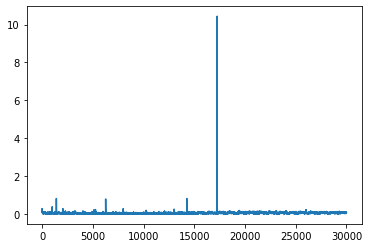

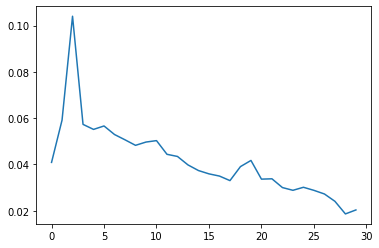

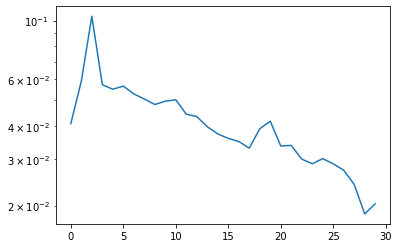

(<__main__.TrainerGeneric at 0x7f3984b41b90>,
 [0.040875279397703704,
  0.059120159144280475,
  0.10400022458285094,
  0.05729797876626253,
  0.055126001504715534,
  0.05661093364469707,
  0.05291942954389378,
  0.05063138159736991,
  0.04824808818940073,
  0.04966320353979245,
  0.05028347374126315,
  0.04436959517560899,
  0.04344339715410024,
  0.039790009276941415,
  0.03735713398642838,
  0.03592978487722576,
  0.034972174683585766,
  0.03301288309972733,
  0.03906130153918639,
  0.041718858282314614,
  0.033648712201043963,
  0.03379299085214734,
  0.030008027859497816,
  0.02882481821021065,
  0.03013262175186537,
  0.028804596873233095,
  0.027237626597750933,
  0.024075193338794633,
  0.018627349090762437,
  0.020344985131872818])

In [ ]:
configlstm100:Config = Config(batch_size = 1000, num_epochs = 30, lr = 0.005)
lstm100 = LSTM_AE(encoding_dim=8, input_dim= configlstm100.n_channels, h_dims=[128,64], h_activ=nn.Tanh(),out_activ=nn.Tanh(), config=configlstm100, use_hidden=True)
train(lstm100, config = configlstm100, loss=nn.L1Loss(reduction='mean'), shuffle=True)

### Plots

#### LSTM Epochs 50

In [ ]:
# n = 24


def plot_output(x, y):
    loss =  get_loss(lstm100, x, y, True, lossf = (lambda x: smooth(x, 0.9)))
    plot_losses(y, loss, sampling=20)
    return loss

plot_output(X_test[0], y_test[0])


array([0.09270526, 0.09270526, 0.09270526, ..., 0.04302919, 0.04299195,
       0.04312359])

In [ ]:

loss_train = []
loss_test = []
loss_val = []

for i in range(len(X_train)):
    x= X_train[i]
    y = y_train[i]
    loss = plot_output(x, y)
    loss_train.append(loss)

for i in range(len(X_val)):
    x= X_val[i]
    y = y_val[i]
    loss = plot_output(x, y)
    loss_val.append(loss)

for i in range(len(X_test)):
    x= X_test[i]
    y = y_test[i]
    loss = plot_output(x, y)
    loss_test.append(loss)


### semi-sup

In [ ]:
class LossSeq(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, out_activ, loss_len, use_hidden = True):
        super(LossSeq, self).__init__()
        self.out_activ = out_activ
        self.use_hidden = use_hidden
        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)
            # self.layers.append(nn.Dropout(0.2))

        self.output_layer = nn.Linear(out_dim*loss_len,1)

        # self.l1 = nn.Linear(out_dim*loss_len,loss_len)
        # self.l2 = nn.Linear(loss_len,1)


    def forward(self, x):
        # x = x.unsqueeze(0)
        # print(x)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)
            # print("no")
            # if self.out_activ and index == self.num_layers - 1:
            #     if(self.use_hidden):
            #         return self.out_activ(h_n).squeeze()

            #     return self.out_activ(x).squeeze()
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        # x=h_n.permute(2,1,0).squeeze(0)
        x = self.output_layer(x)
        return self.out_activ(x)

class LossSeqConv(nn.Module):
    def __init__(self):
        super(LossSeqConv, self).__init__()
        # layer_dims = [input_dim] + h_dims + [out_dim]
        # self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        
        self.conv1 = nn.Conv1d(1, 20, (10))
        self.pool = nn.MaxPool1d(10)
        # self.conv2 = nn.Conv1d(64, 32, (10))
        self.l1 = nn.Linear(980,50)
        self.l2 = nn.Linear(50,1)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        # x = self.conv2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigm(x)
        x = self.l2(x)
        x = self.sigm(x)
        return x

#         model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

def init_lstm(self):
    for m in self.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)

loss_len = 500
# lseq = LossSeq(1,8,[8], nn.Sigmoid(), loss_len).double().cuda()
lseq = LossSeqConv().double().cuda()
lseq_epochs = 10

xx = np.array([loss_test[0][i: i + loss_len] for i in range(0,len(loss_test[0])-loss_len+1) ])

lseq_batch = 30
# lseq.apply(init_lstm)


In [ ]:
gg = xx[4400:5500]
g = torch.from_numpy(gg)
# g = (g - torch.min(g))/(torch.max(g)-torch.min(g))
g = g.double().unsqueeze(1).cuda()
print(g.shape)

lseq(g).shape

torch.Size([1100, 1, 500])


torch.Size([1100, 1])

In [ ]:
xtrain = []
for seq in loss_train:
    xtrain.append(np.array([seq[i: i + loss_len] for i in range(0,len(seq)-loss_len+1) ]))

In [ ]:
print(xtrain[0].shape, y_train[0][loss_len-1:].shape)

(51573, 500) (51573,)


1547
0.4195823162462685
0
17353
0.5521333799993612
5147
0.38049826273379295
0
8413
0.6453171741965196
13017
0.559461898826649
3876
0.3302095757369209
1337
0.2995071684587756
12859
0.6479717813051189
17287
0.5649161792098202
0
Epoch: 1, Loss: 0.18037996290522273
1547
0.4195823162462698
0
17353
0.5521333799993614
5147
0.3804982627337925
0
8413
0.6453171741965198
13017
0.5594618988266478
3876
0.33020957573692317
1337
0.2995071684587754
12859
0.64797178130512
17287
0.5649161792098212
0
Epoch: 2, Loss: 0.1395056494423136
1547
0.4195823162462698
0
17353
0.5521333799993628
5147
0.3804982627337944
0
8413
0.6453171741965191
13017
0.5594618988266493
3876
0.33020957573692233
1337
0.29950716845877606
12859
0.6479717813051196
17287
0.5649161792098206
0
Epoch: 3, Loss: 0.158770087313165
1547
0.41958231624626924
0
17353
0.5521333799993605
5147
0.38049826273379445
0
8413
0.6453171741965202
13017
0.5594618988266482
3876
0.3302095757369227
1337
0.299507168458776
12859
0.6479717813051198
17287
0.56491617

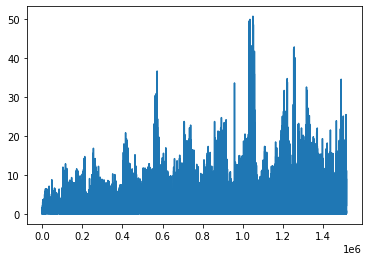

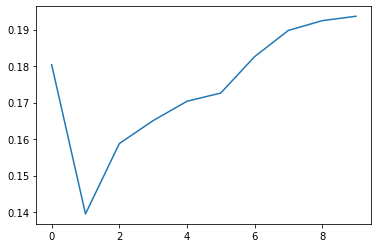

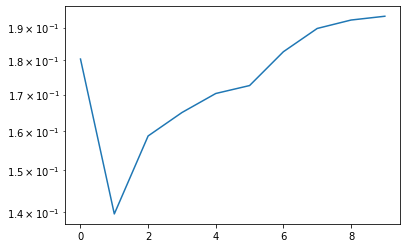

In [ ]:
from random import shuffle
optimizer = Adam(lseq.parameters(), lr=0.0005)
criterion = nn.MSELoss()
def peek(iterable):
    try:
        first = next(iterable)
    except Exception:
        return None
    return first

bs = 500
def train_lseq():
    norms = []
    mean_losses = []


    for epoch in range(1, lseq_epochs+1):
        lseq.train()

        losses = []



        for i in range(len(xtrain)):
            xt = xtrain[i]
            yt = y_train[i][loss_len-1:]
            sum = y_train[i].sum()
            print(sum)
            if(sum == 0):
                continue

            indices = list(range(len(xt)))
            shuffle(indices)
            ratio = 0
            n = 0
            for i in indices:
                y = yt[i:i+bs]
                if not np.any(y==1):
                    continue
                ratio += (y.sum()/len(y))
                n+=1
                x = torch.from_numpy(xt[i:i+bs]).unsqueeze(1).cuda()
                y = torch.from_numpy(y).double().unsqueeze(1).cuda()


                optimizer.zero_grad()

                # print(x.shape, y.shape)
                out = lseq(x)
                # print(out[:,0],y[:,0])

                loss = criterion(out,y)


                loss.backward()
                
                total_norm = 0
                for p in lseq.parameters():
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
                total_norm = total_norm ** (1. / 2)
                norms.append(total_norm)
                # print(net.parameters()[0].grads)
                
                optimizer.step()
                
                losses.append(loss.item())
            print(ratio/n)

        mean_loss = np.mean(losses)
        mean_losses.append(mean_loss)

        print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses, norms

losses, norms = train_lseq()
plt.plot(list(range(len(norms))), norms)
plt.show()
plt.plot(list(range(len(losses))), losses)
plt.show()
plt.yscale('log')
plt.plot(list(range(len(losses))), losses)
plt.show()


In [ ]:
gg

In [ ]:
print(len(loss_test))
# xx = np.array([loss_test[0][i: i + loss_len] for i in range(0,len(loss_test[0])-99) ])

# def test_lseq(net, X_test,sampling=1):
#     torch.cuda.empty_cache()
#     # net.eval()
#     inputs = torch.from_numpy(X_test).unsqueeze(0).unsqueeze(2).cuda()
#     print(inputs.shape)
#     return net(inputs).detach().squeeze(0).squeeze(1).cpu().numpy()



# outs = test_lseq(lseq, loss_test[0])
# plot_losses(y_test[0], outs,sampling=1)
# plot_losses(y_test[0], loss_test[0],sampling=1)

def test_lseq(net, X_test,sampling=1):
    torch.cuda.empty_cache()
    net.eval()
    
    outs = None
    for i in range(0,len(X_test),2000):
        inputs = torch.from_numpy(X_test[i:i+2000]).unsqueeze(1).cuda()
        # print(inputs.shape)
        # return net(inputs).detach().squeeze(0).squeeze(1).cpu().numpy()
        if outs is None:
            outs = net.forward(inputs).detach().cpu()
        else:
            outs = torch.cat([outs, net.forward(inputs).detach().cpu()])


    return outs.squeeze(1).numpy()
allouts=[]
allouts.append(outs)
outs = test_lseq(lseq, xx)
plot_losses(y_test[0], outs,sampling=1)
plot_losses(y_test[0], loss_test[0],sampling=1)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# print(outs.shape, y_test[0].shape)
